In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

In [2]:
import deeptriplet.models
import deeptriplet.datasets

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


## Load VOC2012 dataset

In [4]:
valset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                                            split_file="/home/yardima/Python/experiments/pascal_split/val_obj.txt",
                                            normalize_imagenet=True,
                                            augment=False,
                                            pad_zeros=True,
                                            downsample_label=1)

valloader = data.DataLoader(valset,
                                batch_size=1,
                                num_workers=2,
                                shuffle=False)

trainset = deeptriplet.datasets.PascalDataset(pascal_root="/srv/glusterfs/yardima/datasets/voc12/VOCdevkit/VOC2012",
                        split_file="/home/yardima/Python/experiments/pascal_split/train_obj.txt",
                        normalize_imagenet=True,
                        augment=True,
                        pad_zeros=True,
                        downsample_label=8,
                        scale_low=0.8,
                        scale_high=1.2)

trainloader = data.DataLoader(trainset,
                                batch_size=10,
                                num_workers=4,
                                shuffle=True)

## Load trained embedding model

In [5]:
model_path_random = "/srv/glusterfs/yardima/runs/deeplabv2/lfov-triplet/run_8/models/class-vgg-pascal_epoch-49.pth"

In [6]:
d1 = torch.load(model_path_random, map_location=lambda storage, loc: storage)

In [7]:
net = deeptriplet.models.DeepLab_VGG(n_classes=45)
net = net.cuda()
net.load_state_dict(d1)

In [8]:
net = net.eval().cuda();

## Interactive plot

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
class InteractiveSegmentation:

    def __init__(self, img, lbl, embed):
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.imshow(np.transpose(img.squeeze() / 4 + 0.45, axes=[1, 2, 0]))
        # ax.plot(np.random.rand(10))
        text=ax.text(0,0, "", va="bottom", ha="left")

        self.text = text
        
        self.samples_positive = []
        self.samples_negative = []
        
        self.ax = ax
        self.fig = fig
        
        self.img = img
        self.lbl = lbl
        self.embed = embed
        
        cid = fig.canvas.mpl_connect('button_press_event', lambda x: self.onclick(x))
        
        self.fg_color = np.array([1.0, 0.0, 0.2, 0.6])
        self.bg_color = np.array([0.4, 0.0, 0.0, 0.0])
        
        self.mask = np.zeros(shape=(lbl.shape[0], lbl.shape[1], 4), dtype=np.float32)
        self.maskim = ax.imshow(self.mask)
        
        self.h = int(lbl.shape[0])
        self.w = int(lbl.shape[1])
        
        
    def update_plot(self):
        
        knn = KNeighborsClassifier(n_neighbors=1)
        
        ixp = [i[1] * self.w + i[0] for i in self.samples_positive]
        ixn = [i[1] * self.w + i[0] for i in self.samples_negative]
        
        X = self.embed.reshape(self.w * self.h, -1)[ixp + ixn, :]
        y = np.array([1] * len(ixp) + [0] * len(ixn))
        
        print(X.shape)
        print(y.shape)
        
        knn.fit(X, y)
        
        pred = knn.predict(self.embed.reshape(self.w * self.h, -1)).reshape(self.h, self.w)
        
        r = np.zeros(pred.shape)
        g = np.zeros(pred.shape)
        b = np.zeros(pred.shape)
        a = np.zeros(pred.shape)
        
        r[pred == 1] = self.fg_color[0]
        g[pred == 1] = self.fg_color[1]
        b[pred == 1] = self.fg_color[2]
        a[pred == 1] = self.fg_color[3]
        
        self.mask[:,:,0] = r
        self.mask[:,:,1] = g
        self.mask[:,:,2] = b
        self.mask[:,:,3] = a
        
        self.maskim.set_data(self.mask)
        


    def onclick(self, event):
        point = (int(round(event.xdata)), int(round(event.ydata)))

        if event.button == 1:
            self.samples_positive.append(point)
            self.samples_positive = list(set(self.samples_positive))
            self.ax.add_artist(plt.Circle(point, 2.2, color='r'))
        else:
            self.samples_negative.append(point)
            self.samples_negative = list(set(self.samples_negative))
            self.ax.add_artist(plt.Circle(point, 2.2, color='b'))
            
        if len(self.samples_negative) > 0 and len(self.samples_positive) > 0:
            self.update_plot()
        
        tx = 'button=%d, xdata=%d, ydata=%d' % (event.button, point[0], point[1])
        self.text.set_text(tx)
        
        ax.draw()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


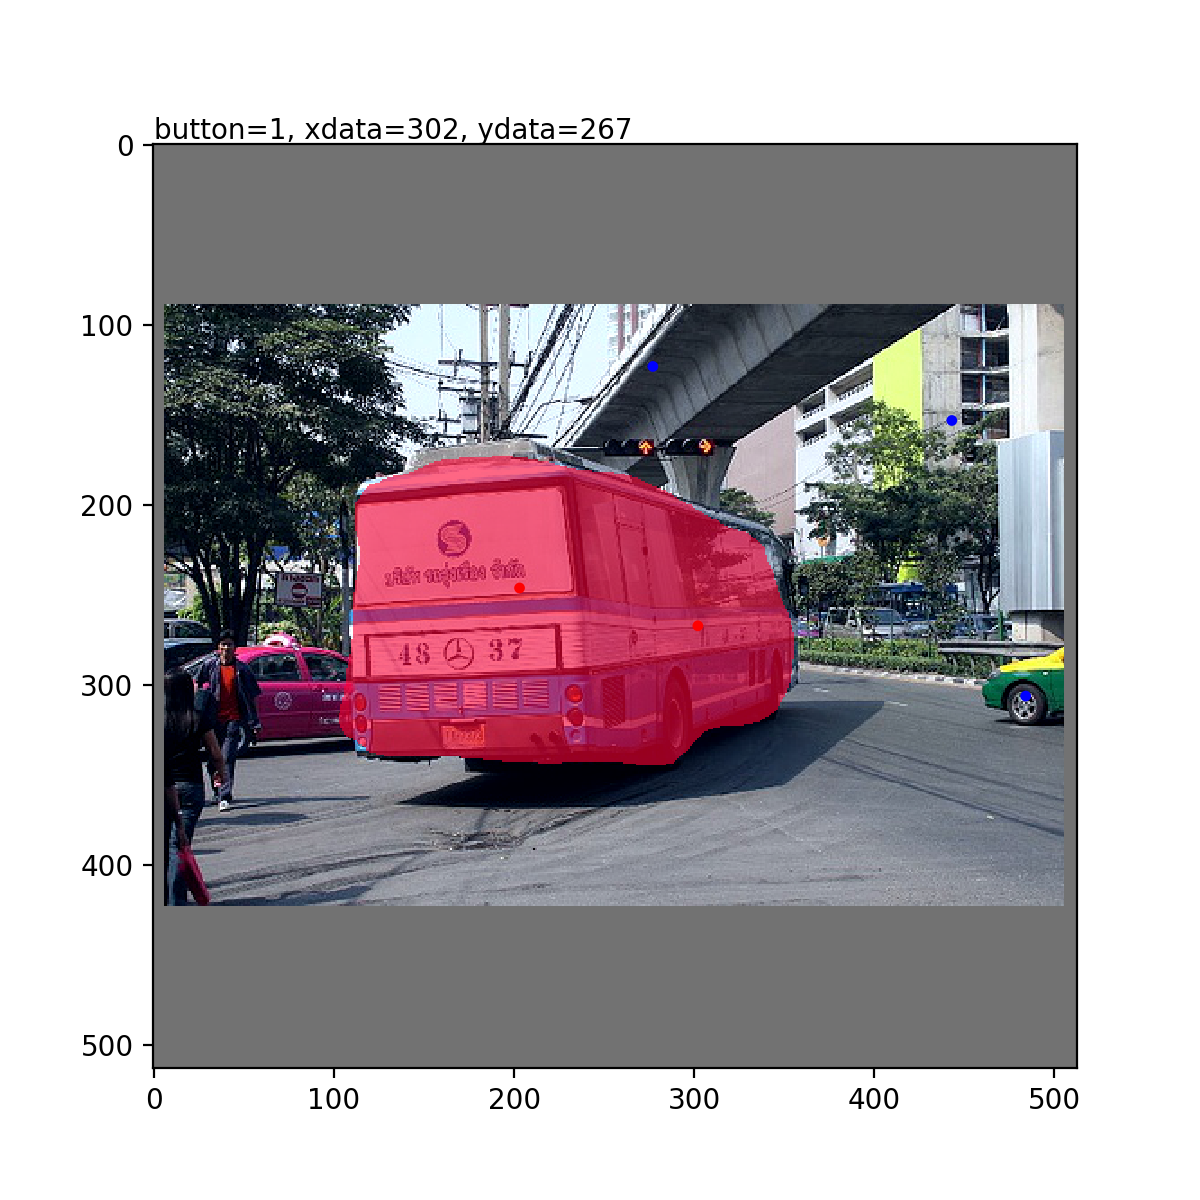

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
img, lbl = valset[115]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


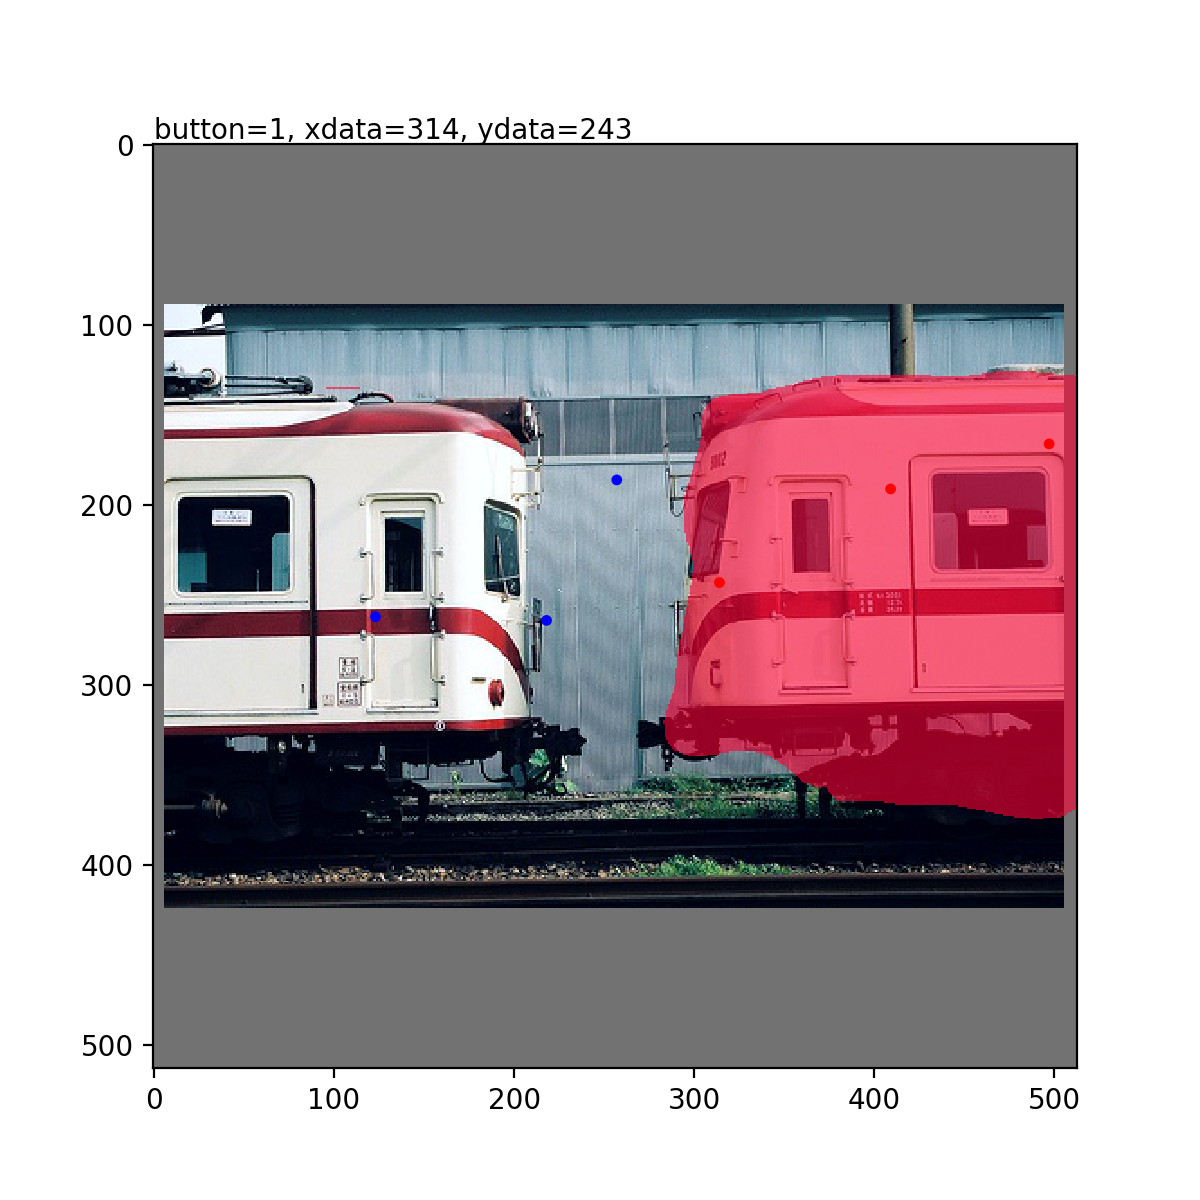

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [28]:
img, lbl = valset[1]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


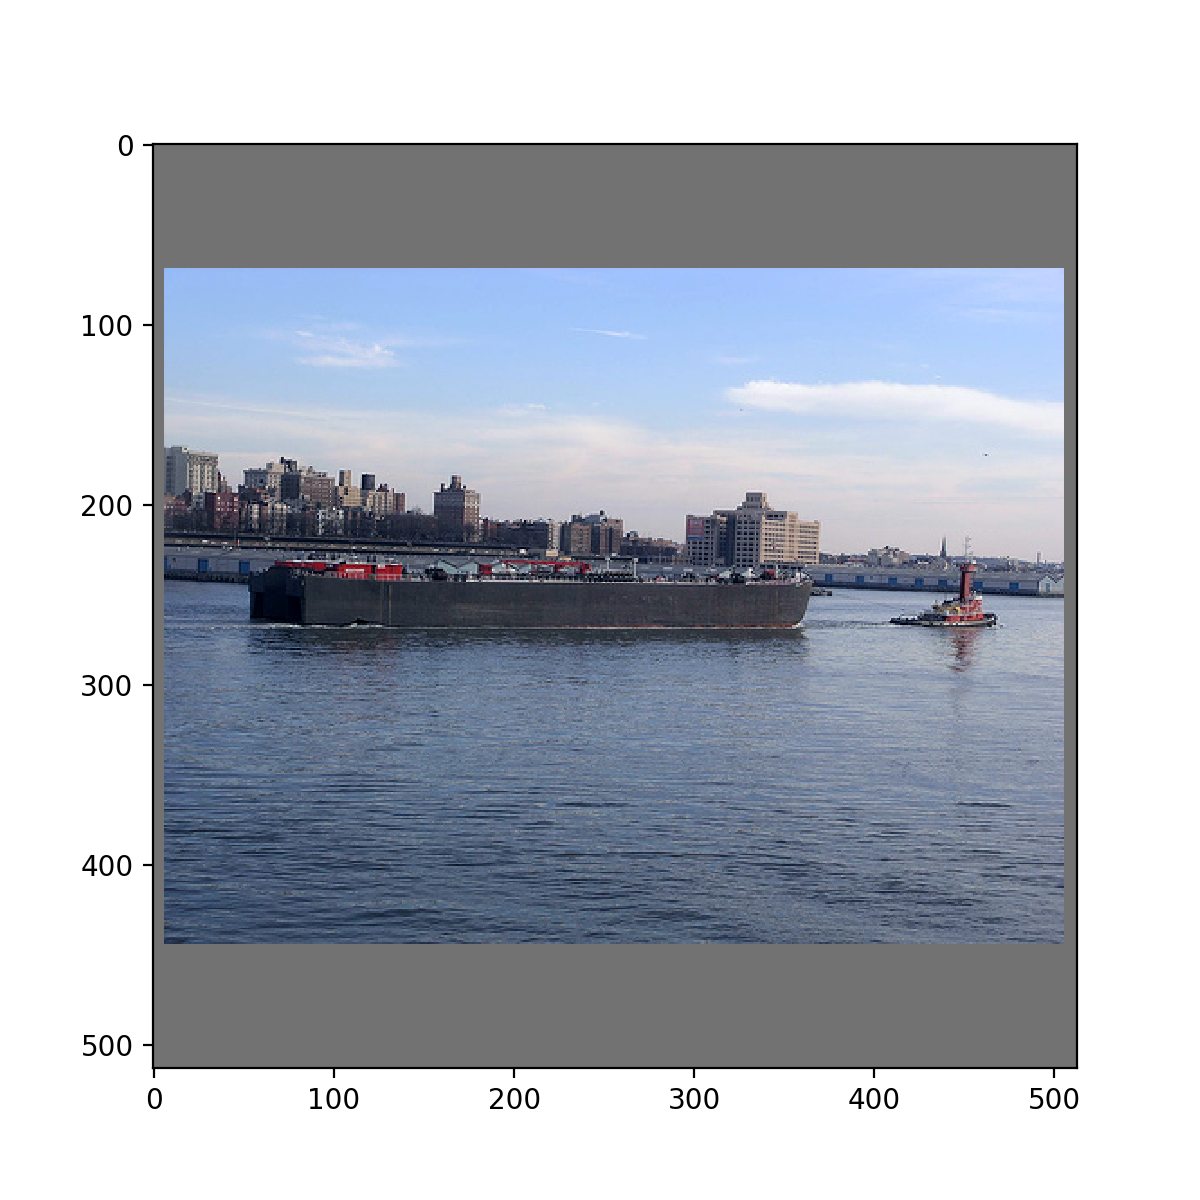

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [26]:
img, lbl = valset[590]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


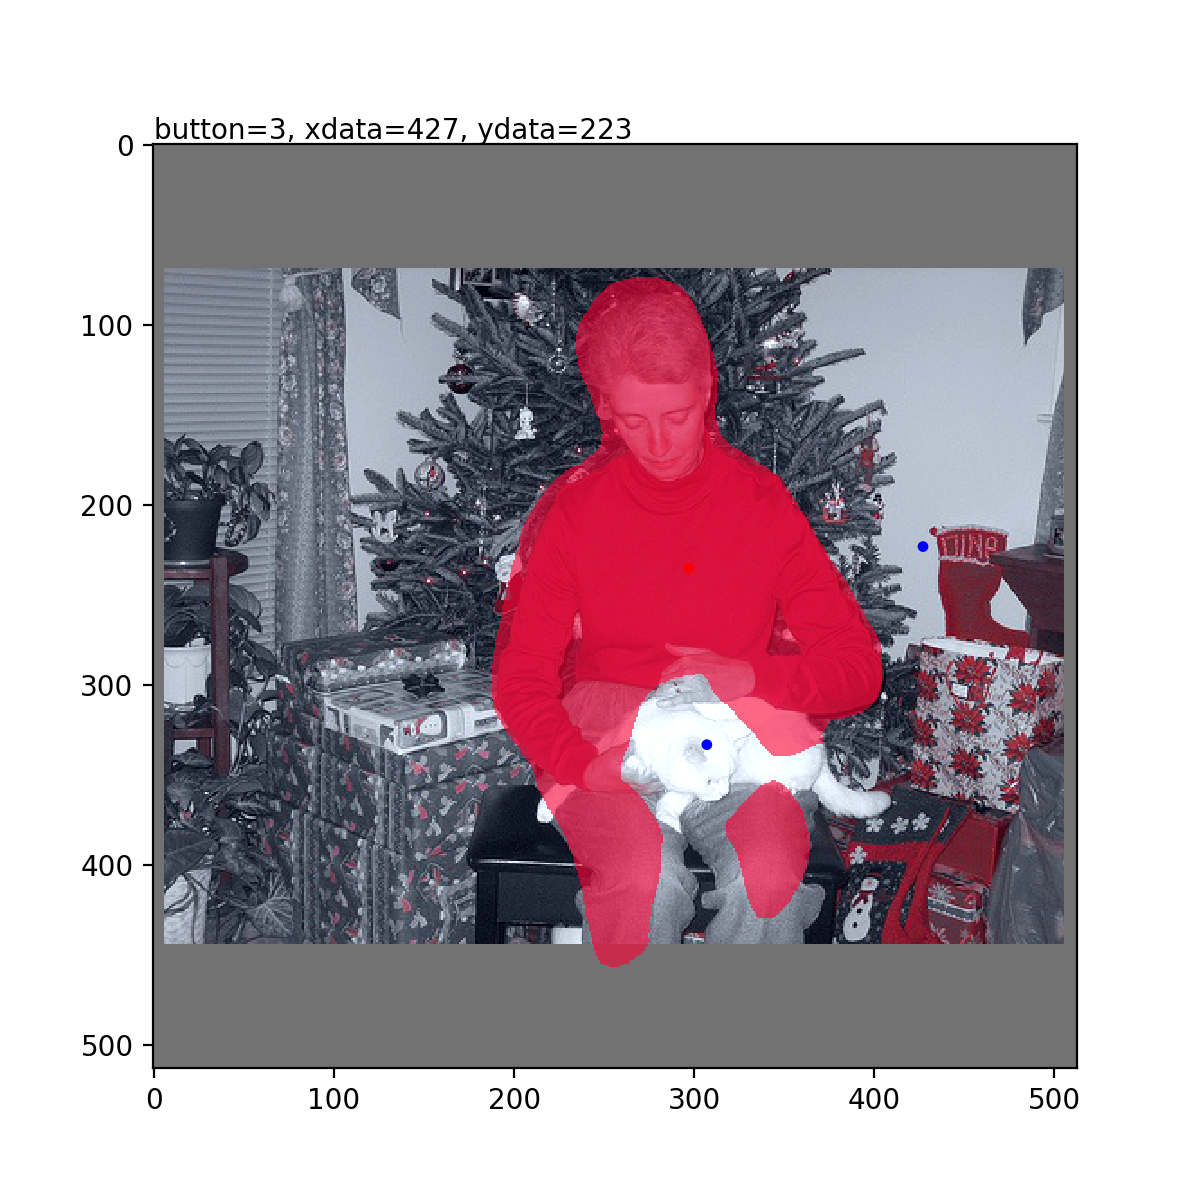

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [18]:
img, lbl = valset[100]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


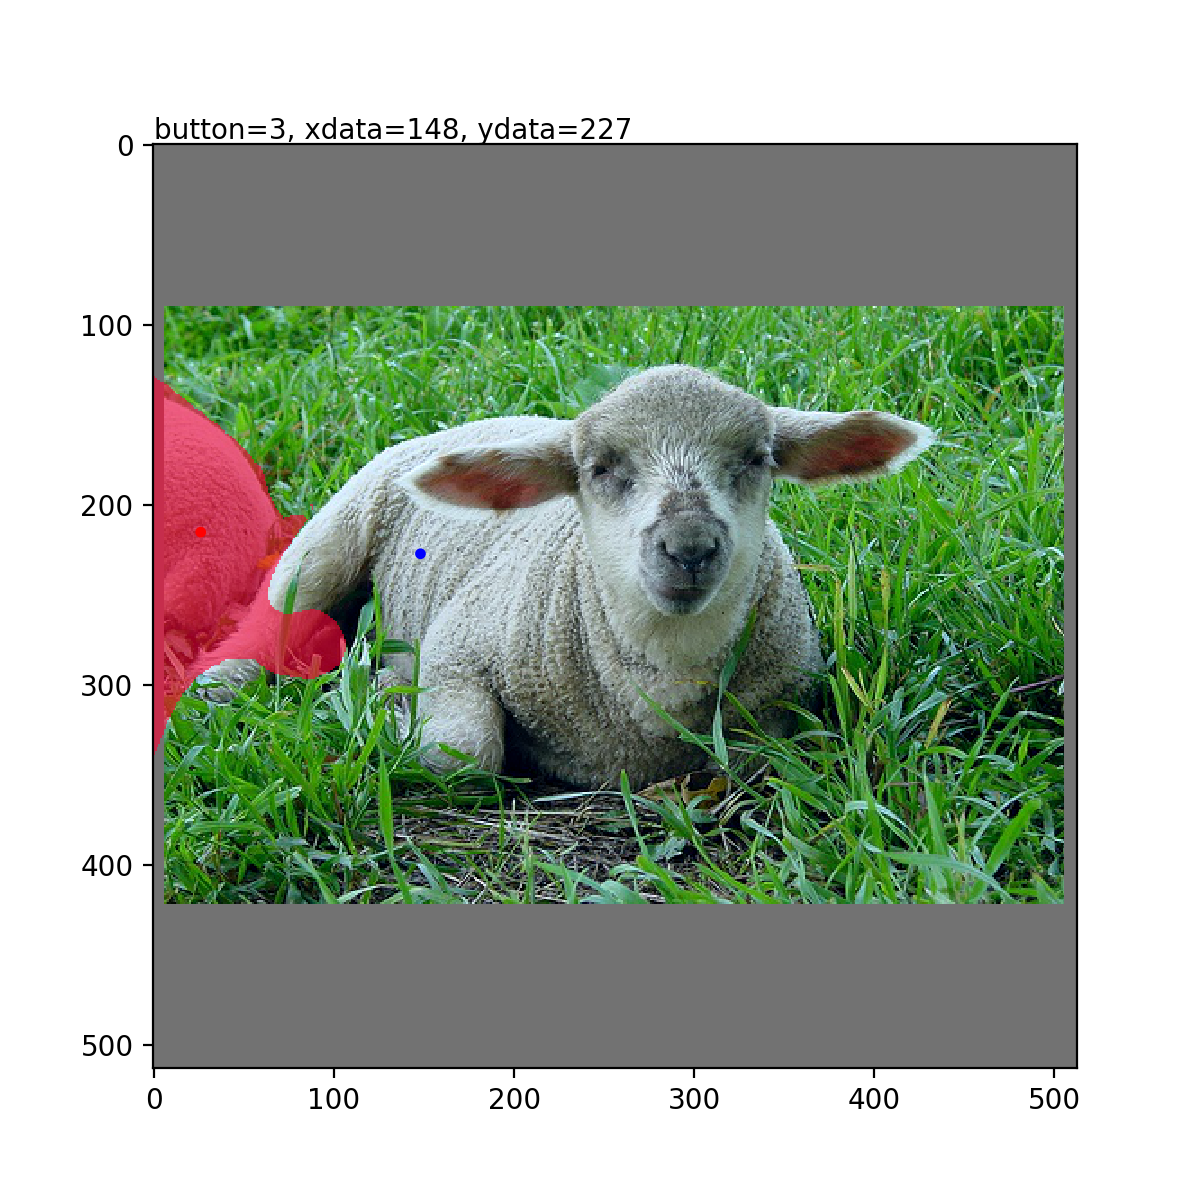

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [55]:
img, lbl = valset[5]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

<IPython.core.display.Javascript object>


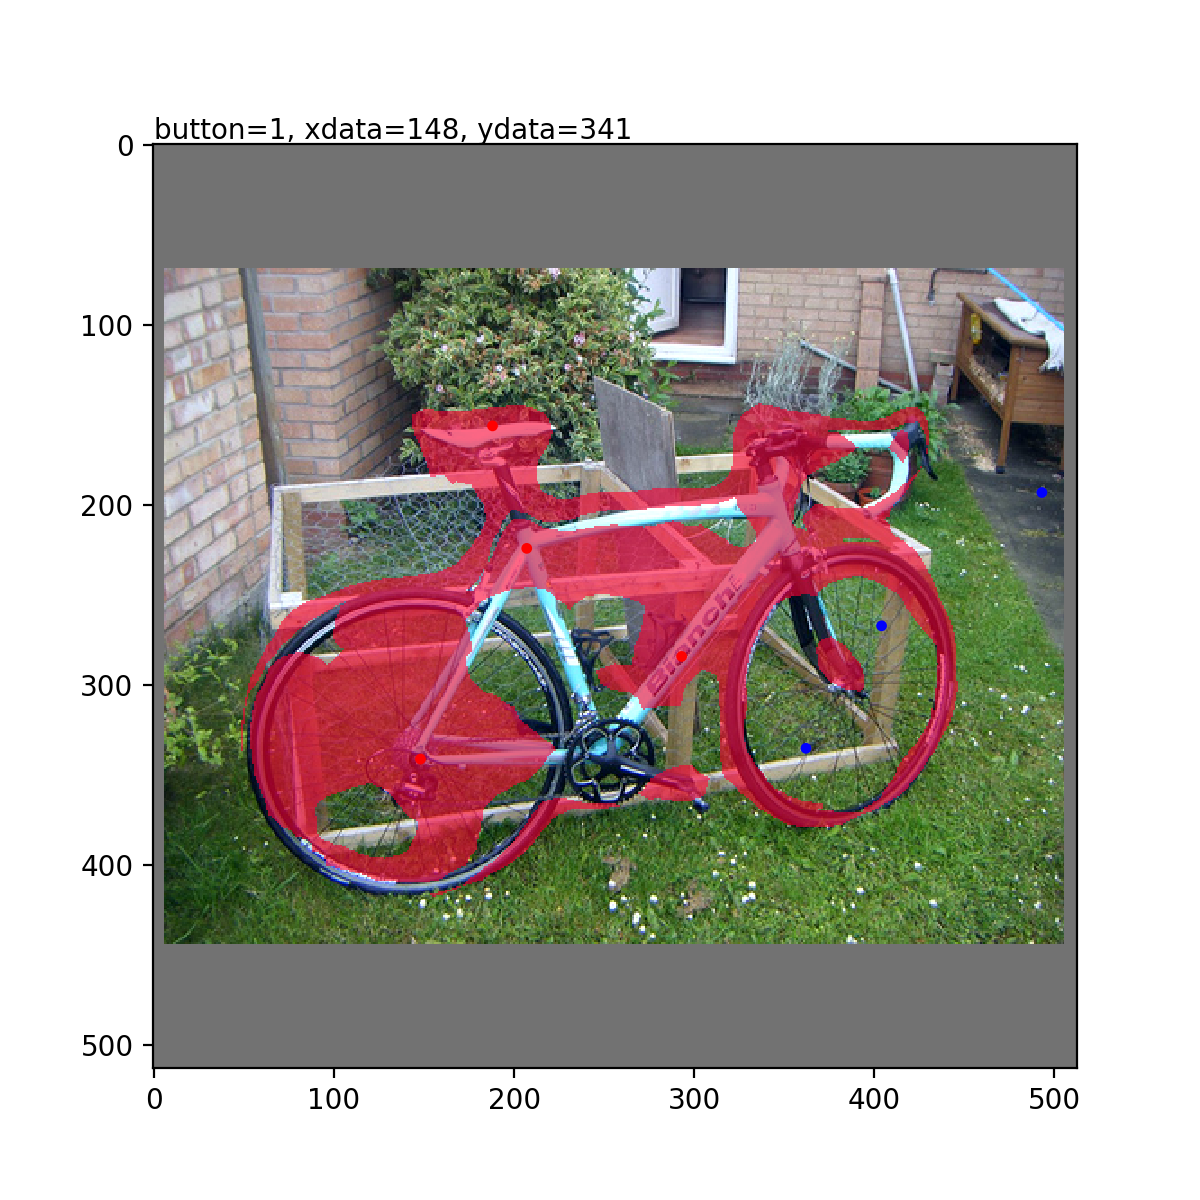

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [25]:
img, lbl = valset[800]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


<IPython.core.display.Javascript object>


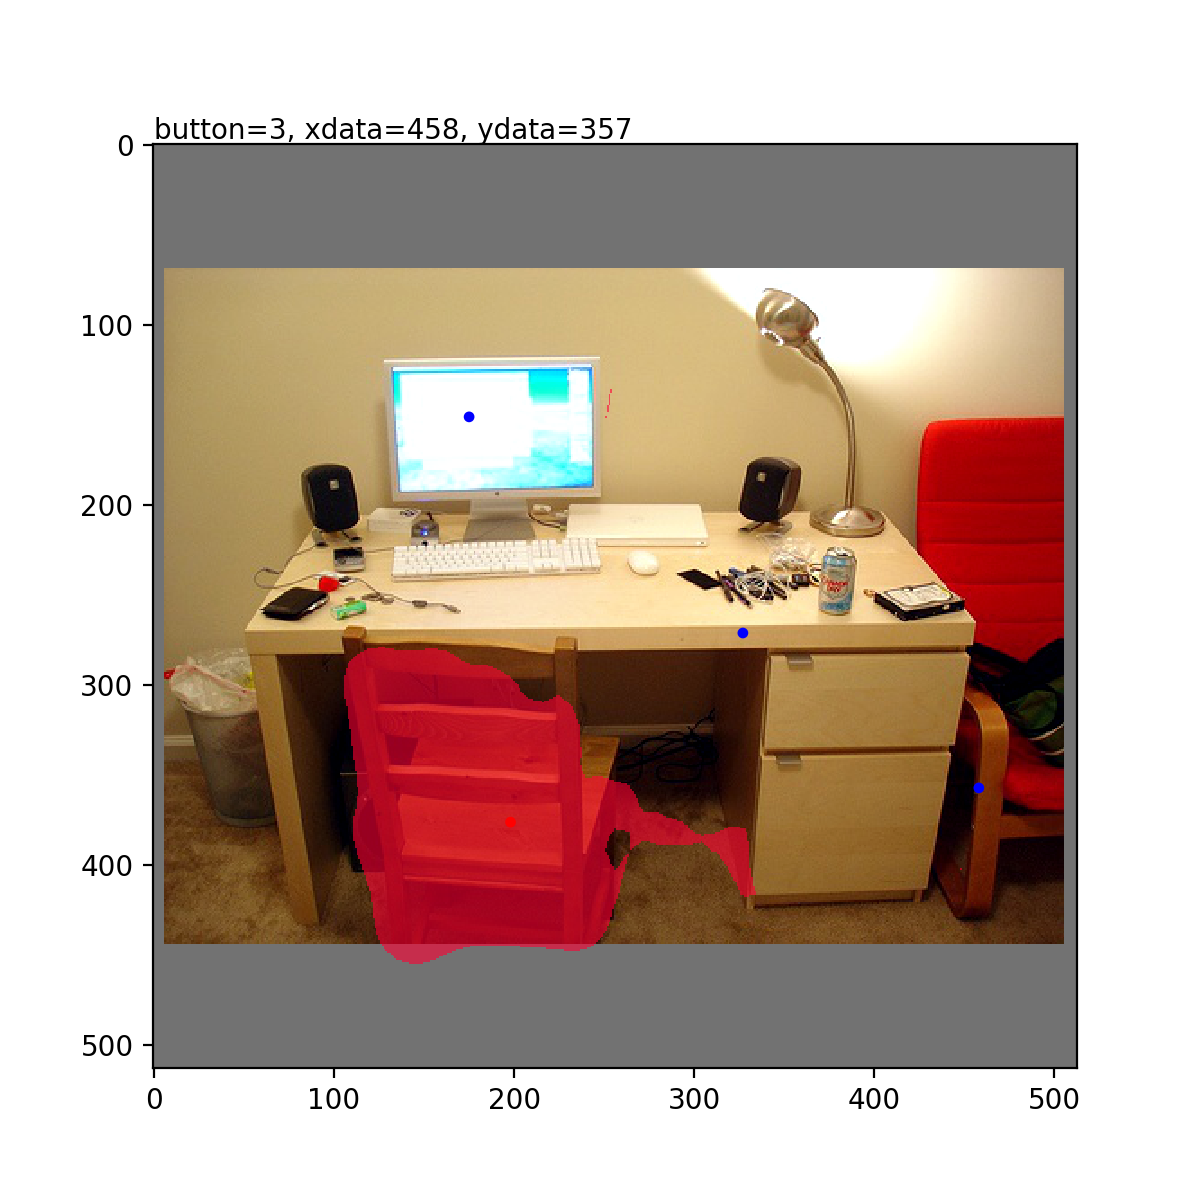

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [12]:
img, lbl = valset[150]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())

<IPython.core.display.Javascript object>


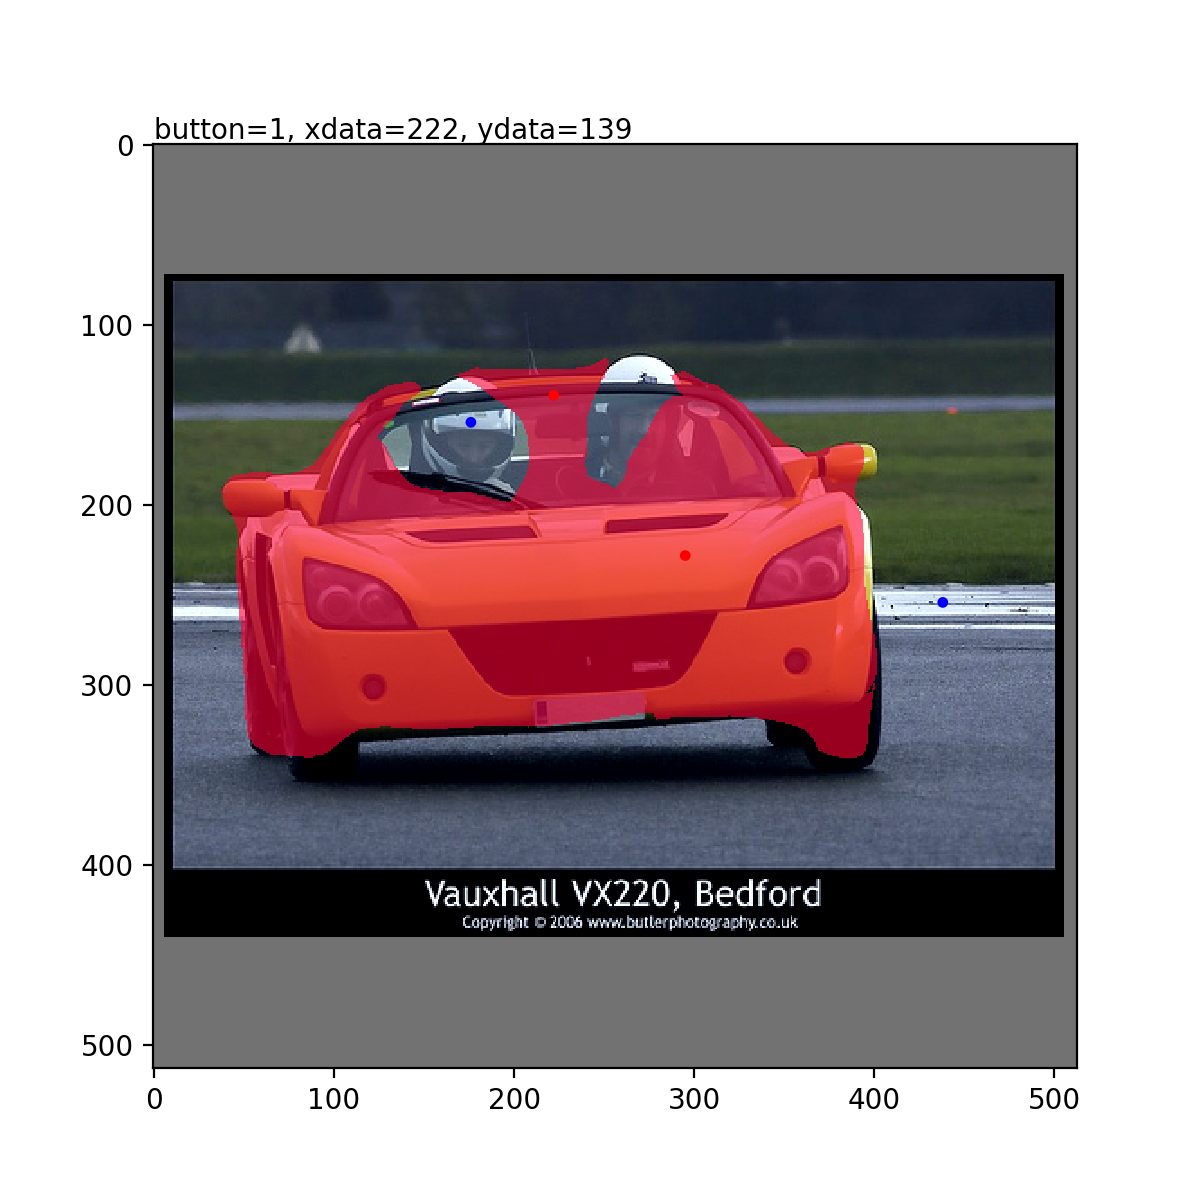

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [83]:
img, lbl = valset[250]

with torch.no_grad():
    upsample = nn.UpsamplingBilinear2d(size=(lbl.shape[0], lbl.shape[1]))
    
    embed = net.forward(img.cuda().unsqueeze(0))
    embed = upsample(embed)
    
    embed = embed.squeeze().permute(1, 2, 0).cpu()

p = InteractiveSegmentation(img.numpy(), lbl.numpy(), embed.numpy())